In [35]:
import os
import numpy as np
import pandas as pd

def count_new_photons(current_frame, previous_frame):
    """Count new photons in the current frame compared to the previous frame."""
    return np.sum((current_frame > previous_frame) & (current_frame > 0))

def process_frames(folder_path):
    """Process each frame in the folder and count new photons."""
    frame_files = sorted([f for f in os.listdir(folder_path) if f.endswith('.asc')])
    previous_frame = None
    new_photons_counts = []

    for file in frame_files:
        # Read the current frame
        current_frame = np.loadtxt(os.path.join(folder_path, file))

        # Count new photons if not the first frame
        if previous_frame is not None:
            new_photons = count_new_photons(current_frame, previous_frame)
            new_photons_counts.append({'frame': file, 'new_photons': new_photons})

        # Update the previous frame
        previous_frame = current_frame

    return new_photons_counts

# Example usage
folder_path = 'Heralded Imaing SM'  # Update this with the correct folder path
new_photons_data = process_frames(folder_path)

# Convert to DataFrame and save to CSV
df = pd.DataFrame(new_photons_data)
csv_output_path = 'new_photons_counts.csv'
df.to_csv(csv_output_path, index=False)

print(f"Data processed and saved to {csv_output_path}")



Data processed and saved to new_photons_counts.csv


In [38]:
import pandas as pd
from scipy.optimize import linear_sum_assignment
from scipy.stats import linregress
import numpy as np

# Function to align data using the cost matrix approach
def align_data(photon_file, expectation_file):
    # Load data from CSV files
    df_photons = pd.read_csv(photon_file)
    df_expectations = pd.read_csv(expectation_file)

    # Ensure that there are equal numbers of data points in both files
    min_length = min(len(df_photons), len(df_expectations))
    df_photons = df_photons.head(min_length)
    df_expectations = df_expectations.head(min_length)

    # Create cost matrix (using absolute difference here)
    cost_matrix = abs(df_photons['new_photons'].values[:, np.newaxis] - df_expectations['E_countercomplexity'].values)

    # Apply the Hungarian algorithm
    row_ind, col_ind = linear_sum_assignment(cost_matrix)

    # Return the aligned data
    aligned_photons = df_photons.iloc[row_ind].reset_index(drop=True)
    aligned_expectations = df_expectations.iloc[col_ind].reset_index(drop=True)

    return aligned_photons, aligned_expectations

# Example usage (you'll need to update the file paths according to your files)
photon_file = 'new_photons_counts.csv'
expectation_file = 'quantum_expectation_values.csv'
aligned_photons, aligned_expectations = align_data(photon_file, expectation_file)

# For demonstration, let's just print the first few rows of the aligned data
print("Aligned Photon Counts:\n", aligned_photons.head())
print("\nAligned Expectation Values:\n", aligned_expectations.head())

# Assuming aligned_photons and aligned_expectations are your aligned data from the previous script
x = aligned_photons['new_photons']
y = aligned_expectations['E_countercomplexity']

# Calculate Pearson correlation coefficient and R² value
correlation_coefficient, p_value = np.corrcoef(x, y)[0, 1], linregress(x, y).pvalue
r_squared = correlation_coefficient**2

# Print the statistics
print(f"R² (Coefficient of Determination): {r_squared:.2f}")
print(f"Pearson Correlation Coefficient: {correlation_coefficient:.2f}")
print(f"P-Value: {p_value:.2e}")

# Calculate the difference between 'new_photons' and 'E_countercomplexity'
difference = aligned_photons['new_photons'] - aligned_expectations['E_countercomplexity']

# Add the difference to the aligned_photons DataFrame
aligned_photons['E_countercomplexity'] = aligned_expectations['E_countercomplexity']
aligned_photons['difference'] = difference

# Save the updated DataFrame to a new CSV file
output_file = 'sorted_new_photons.csv'
aligned_photons.to_csv(output_file, index=False)

print(f"Sorted photon data saved to {output_file}")

Aligned Photon Counts:
       frame  new_photons
0  0002.asc            0
1  0003.asc            7
2  0004.asc           15
3  0005.asc           16
4  0006.asc            7

Aligned Expectation Values:
           Time  E_complexity  E_countercomplexity  E_interaction    E_total
0  3769.930847     31.039186             0.000149      -0.000666  31.038669
1  1875.463077     24.672368             6.497982      -0.000335  31.170016
2  1146.283033     16.222992            14.998089      -0.000206  31.220875
3  1712.422820     15.179967            16.001669      -0.000306  31.181330
4  1624.401087     25.017701             6.170173      -0.000290  31.187583
R² (Coefficient of Determination): 0.74
Pearson Correlation Coefficient: 0.86
P-Value: 0.00e+00
Sorted photon data saved to sorted_new_photons.csv


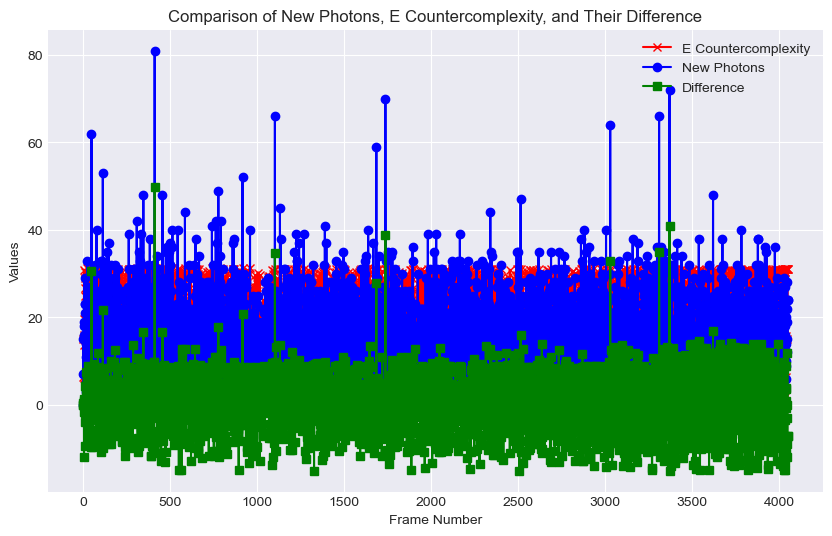

In [41]:
import matplotlib.pyplot as plt

# Data for plotting
x_axis = range(len(aligned_photons))  # Assuming equal length for both datasets
new_photons = aligned_photons['new_photons']
e_countercomplexity = aligned_photons['E_countercomplexity']
difference = aligned_photons['difference']

# Creating the plot
plt.figure(figsize=(10, 6))
plt.plot(x_axis, e_countercomplexity, label='E Countercomplexity', color='red', marker='x')
plt.plot(x_axis, new_photons, label='New Photons', color='blue', marker='o')
plt.plot(x_axis, difference, label='Difference', color='green', marker='s')

# Adding titles and labels
plt.title('Comparison of New Photons, E Countercomplexity, and Their Difference')
plt.xlabel('Frame Number')
plt.ylabel('Values')
plt.legend()

# Show the plot
plt.show()


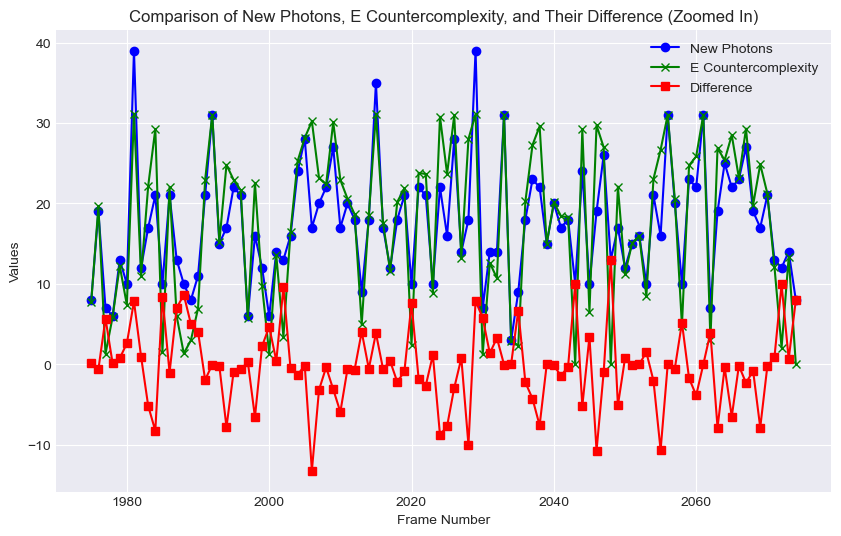

In [52]:
import matplotlib.pyplot as plt

# Assuming the DataFrame aligned_photons contains the data
# Zooming in on 100 time steps in the middle of the data
mid_point = len(aligned_photons) // 2
start = mid_point - 50
end = mid_point + 50

# Slicing the data for the specified range
x_axis = range(start, end)
new_photons = aligned_photons['new_photons'][start:end]
e_countercomplexity = aligned_photons['E_countercomplexity'][start:end]
difference = aligned_photons['difference'][start:end]

# Creating the plot
plt.figure(figsize=(10, 6))

plt.plot(x_axis, new_photons, label='New Photons', color='blue', marker='o')
plt.plot(x_axis, e_countercomplexity, label='E Countercomplexity', color='green', marker='x')
plt.plot(x_axis, difference, label='Difference', color='red', marker='s')

# Adding titles and labels
plt.title('Comparison of New Photons, E Countercomplexity, and Their Difference (Zoomed In)')
plt.xlabel('Frame Number')
plt.ylabel('Values')
plt.legend()

# Show the plot
plt.show()



In [64]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Transforming the data into polynomial features
degree = 7  # You can adjust the degree as needed
poly_features = PolynomialFeatures(degree=degree)
new_photons_poly = poly_features.fit_transform(aligned_photons['new_photons'].values.reshape(-1, 1))

# Fit a linear regression model
model = LinearRegression()
model.fit(new_photons_poly, aligned_expectations['E_countercomplexity'])

# Predict and calculate R² value
y_pred = model.predict(new_photons_poly)
r2 = r2_score(aligned_expectations['E_countercomplexity'], y_pred)

print(f"R² value for Polynomial Regression (Degree {degree}): {r2:.2f}")

# Adding the predicted values to the DataFrame
aligned_photons['predicted_E_countercomplexity'] = y_pred

# Save the updated DataFrame to a new CSV file
updated_csv_file = 'updated_new_photons.csv'
aligned_photons.to_csv(updated_csv_file, index=False)

print(f"Updated data saved to {updated_csv_file}")


R² value for Polynomial Regression (Degree 7): 0.88
Updated data saved to updated_new_photons.csv


In [59]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score
import pandas as pd

# Load your data
# aligned_photons = pd.read_csv('path_to_new_photons.csv')
# aligned_expectations = pd.read_csv('path_to_expectations.csv')

# Prepare the feature and target variables
X = aligned_photons[['predicted_E_countercomplexity']]  # Features
y = aligned_expectations['E_countercomplexity']  # Target

# Random Forest Regression
rf_model = RandomForestRegressor(n_estimators=100, random_state=0)
rf_model.fit(X, y)
y_pred_rf = rf_model.predict(X)
r2_rf = r2_score(y, y_pred_rf)

# Gradient Boosting Regression
gbm_model = GradientBoostingRegressor(n_estimators=100, random_state=0)
gbm_model.fit(X, y)
y_pred_gbm = gbm_model.predict(X)
r2_gbm = r2_score(y, y_pred_gbm)

# Print the R² values for both models
print(f"R² value for Random Forest Regression: {r2_rf:.2f}")
print(f"R² value for Gradient Boosting Regression: {r2_gbm:.2f}")


R² value for Random Forest Regression: 0.91
R² value for Gradient Boosting Regression: 0.91
